In [1]:
#tensorflow==2.10.0
import os
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf

In [2]:
print(tf.__version__)

2.15.0


In [3]:
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Masking
from tensorflow.python.client import device_lib
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Reshape, Dropout, Flatten
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from pickle import dump
from pickle import load
import pandas as pd

In [4]:
df = pd.read_csv("./dfcsv3.csv")
df_test = pd.read_csv("./dfcsv_anomaly.csv")
scaler = MinMaxScaler()
arr = df.to_numpy()
arr_test = df_test.to_numpy()
train_scaled = scaler.fit_transform(arr[:,2:])
test_scaled = scaler.transform(arr_test[:,2:])
dump(scaler,open('./minmax_scaler.pkl','wb'))

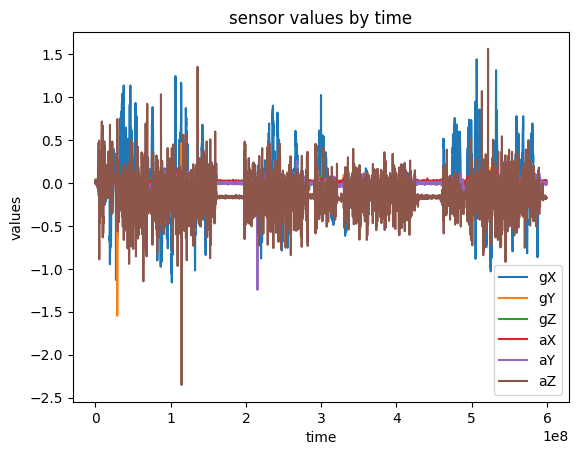

In [5]:
fig2 = plt.figure()
ax = fig2.add_subplot(1,1,1)
ax.plot(df['time'],df['gX'],label='gX')
ax.plot(df['time'],df['gY'],label='gY')
ax.plot(df['time'],df['gZ'],label='gZ')
ax.plot(df['time'],df['aX'],label='aX')
ax.plot(df['time'],df['aY'],label='aY')
ax.plot(df['time'],df['aZ'],label='aZ')
ax.set_xlabel('time')
ax.set_ylabel('values')
ax.set_title('sensor values by time')
ax.legend()
fig2.show()

In [6]:
def create_sequences(data, sequence_length):
    sequences = []
    for i in range(len(data) - sequence_length):
        sequence = data[i:i + sequence_length].flatten()
        sequences.append(sequence)
    return np.array(sequences)

SEQ_LEN=16

sequences = create_sequences(train_scaled, SEQ_LEN)
sequences_test = create_sequences(test_scaled,SEQ_LEN)


In [7]:
print(sequences.shape)
print(sequences_test.shape)

(6014, 128)
(797, 128)


In [8]:
def create_cnn_autoencoder(sequence_length,num_features):
    inputs = Input(shape=(sequence_length*num_features))
    inputs_reshape = Reshape((sequence_length,num_features,1))(inputs)

    encoded = Conv2D(16,(3,3),activation='relu',padding='same')(inputs_reshape)
    encoded = MaxPooling2D((2,2),padding='same')(encoded)
    encoded = Dropout(0.1)(encoded)

    encoded = Conv2D(8,(3,3),activation='relu',padding='same')(encoded)
    encoded = MaxPooling2D((2,2),padding='same')(encoded)
    encoded = Dropout(0.1)(encoded)

    decoded = Conv2D(8,(3,3),activation='relu',padding='same')(encoded)
    decoded = UpSampling2D((2,2))(decoded)
    decoded = Conv2D(16,(3,3),activation='relu',padding='same')(decoded)
    decoded = UpSampling2D((2,2))(decoded)

    decoded = Conv2D(1,(3,3),activation='sigmoid',padding='same')(decoded)
    decoded = Flatten()(decoded)
    autoencoder = Model(inputs,decoded)
    autoencoder.compile(optimizer='adam',loss='binary_crossentropy')
    return autoencoder

autoencoder = create_cnn_autoencoder(SEQ_LEN,8)
early_stopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

In [9]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128)]             0         
                                                                 
 reshape (Reshape)           (None, 16, 8, 1)          0         
                                                                 
 conv2d (Conv2D)             (None, 16, 8, 16)         160       
                                                                 
 max_pooling2d (MaxPooling2  (None, 8, 4, 16)          0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 8, 4, 16)          0         
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 4, 8)           1160      
                                                             

In [11]:
history=autoencoder.fit(sequences, sequences, epochs=30, batch_size=8, validation_split=0.1, callbacks=[early_stopping]).history

Epoch 1/30
677/677 [==============================] - 3s 4ms/step - loss: 0.6313 - val_loss: 0.6292
Epoch 2/30
677/677 [==============================] - 3s 4ms/step - loss: 0.6312 - val_loss: 0.6289
Epoch 3/30
677/677 [==============================] - 3s 4ms/step - loss: 0.6310 - val_loss: 0.6289
Epoch 4/30
677/677 [==============================] - 3s 4ms/step - loss: 0.6309 - val_loss: 0.6287
Epoch 5/30
677/677 [==============================] - 3s 4ms/step - loss: 0.6309 - val_loss: 0.6287
Epoch 6/30
677/677 [==============================] - 3s 4ms/step - loss: 0.6308 - val_loss: 0.6287
Epoch 7/30
677/677 [==============================] - 3s 4ms/step - loss: 0.6308 - val_loss: 0.6286
Epoch 8/30
677/677 [==============================] - 3s 4ms/step - loss: 0.6308 - val_loss: 0.6287
Epoch 9/30
677/677 [==============================] - 3s 4ms/step - loss: 0.6307 - val_loss: 0.6286
Epoch 10/30
677/677 [==============================] - 3s 4ms/step - loss: 0.6307 - val_loss: 0.6285

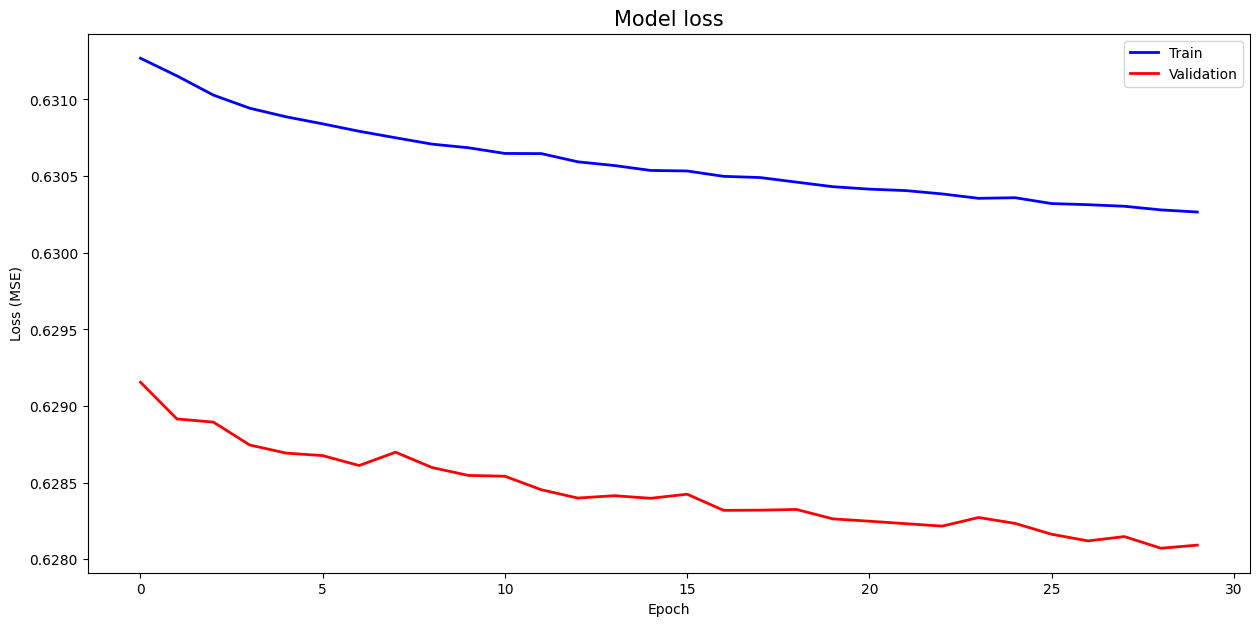

In [12]:
fig,ax = plt.subplots(figsize=(15,7))
ax.plot(history['loss'],'b',label='Train',linewidth=2)
ax.plot(history['val_loss'],'r',label='Validation',linewidth=2)
ax.set_title('Model loss',fontsize=15)
ax.set_ylabel('Loss (MSE)')
ax.set_xlabel('Epoch')
ax.legend()
plt.show()

In [13]:
pred_train = autoencoder.predict(sequences)

188/188 [==============================] - 1s 2ms/step


In [14]:
def calculate_error(original,reconstructed):
  return np.abs(original-reconstructed)

reconstructed_error = calculate_error(sequences,pred_train)

print(reconstructed_error[0])
print(reconstructed_error[1])

[2.53900393e-02 1.86380749e-03 2.64993169e-02 2.39652447e-03
 1.48234822e-02 1.53097190e-02 2.09912071e-01 1.48621841e-01
 1.53484415e-02 8.17199590e-03 2.05545815e-02 4.70652244e-02
 6.87872798e-03 2.39019381e-03 3.87647326e-02 1.02043569e-01
 3.25197691e-02 1.66543337e-02 2.69645486e-02 8.43259917e-02
 1.08892207e-02 2.94618132e-03 1.27752507e-01 1.02836345e-02
 3.14743589e-02 1.12245594e-02 5.32909905e-02 2.87379189e-02
 3.07116891e-03 1.11377813e-03 9.98358146e-02 3.58246254e-01
 2.47456440e-02 5.24412344e-03 3.14432118e-02 3.03236144e-02
 8.28294538e-03 1.06166063e-02 2.77261702e-01 8.36333198e-02
 2.61719977e-02 3.78376706e-03 4.08697284e-02 5.98574398e-02
 1.40425691e-03 4.22722183e-02 1.76432070e-03 3.91940059e-02
 5.89791994e-03 6.24196783e-03 1.43351109e-02 8.60369665e-02
 8.75349854e-03 3.07662693e-02 5.88223512e-02 3.94880224e-01
 4.17780626e-03 1.96992110e-03 4.53366320e-03 4.96083361e-02
 1.27752027e-03 1.41360315e-02 2.39325891e-01 1.23048445e-01
 7.64261412e-03 4.074739

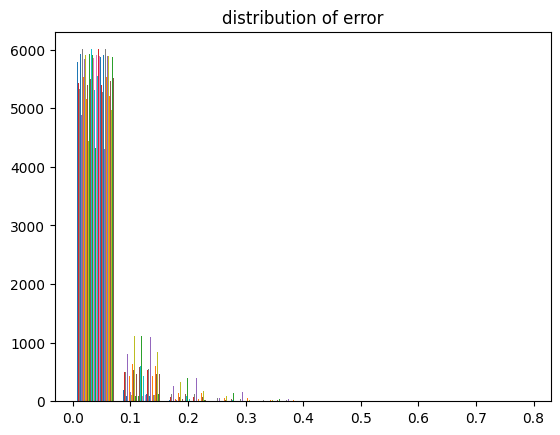

In [15]:
plt.hist(reconstructed_error)
plt.title('distribution of error')
plt.show()

In [16]:
pred_test = autoencoder.predict(sequences_test)
#print(pred_test)
pred_test.shape

25/25 [==============================] - 0s 5ms/step


(797, 128)

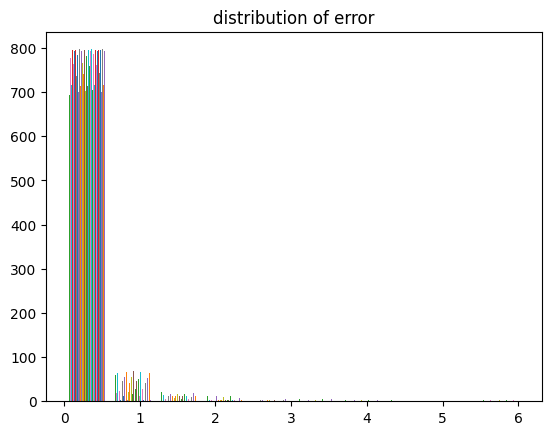

In [17]:
reconstructed_error_test = calculate_error(sequences_test,pred_test)
plt.hist(reconstructed_error_test)
plt.title('distribution of error')
plt.show()

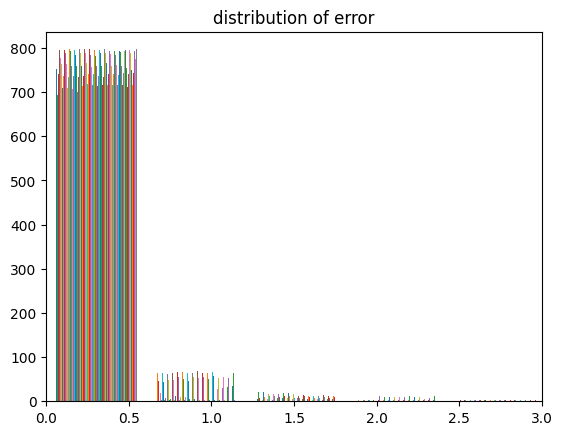

In [18]:
reconstructed_error_test = calculate_error(sequences_test,pred_test)
plt.hist(reconstructed_error_test)
plt.title('distribution of error')
plt.xlim([0, 3])
plt.show()

In [19]:
autoencoder.save('model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [20]:
scaler = load(open('./minmax_scaler.pkl','rb'))

min_ = scaler.min_
scale_ = scaler.scale_

print("min_: ", min_)
print("scale_: ", scale_)

min_:  [0.44566611 0.76919872 0.6322389  0.60612691 0.82548109 0.60107335
 0.49998736 0.48786925]
scale_:  [0.3845948  0.49740237 3.15106305 2.18818381 0.66357001 0.2555584
 0.32877444 0.34700859]


In [21]:
def representative_dataset_gen():
    for i in range(500):
      input = test_scaled[i:i+1].astype(np.float32)
      yield [input]

# model directory.
MODEL_DIR = "model"
#autoencoder.save(MODEL_DIR, save_format="tf",signatures=concrete_func)
autoencoder.save(MODEL_DIR, save_format="tf")



In [3]:

converter = tf.lite.TFLiteConverter.from_saved_model(MODEL_DIR)
#converter.optimizations = [tf.lite.Optimize.DEFAULT]
#converter.representative_dataset = representative_dataset_gen
#converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
#converter.inference_input_type = tf.int8
#converter.inference_output_type = tf.int8
tflite_model = converter.convert()
with open("model.tflite","wb") as f:
    f.write(tflite_model)

In [ ]:
!xxd -i model.tflite > model.cc